#### This script is designed to do the initial data wrangling on three recipe datasets, in json format, which together total 120K+ recipes across three website (Epicurious, AllRecipes, and Food Network). These recipes were initially webscraped by Ryan Lee of the blog [Eight Portions](https://eightportions.com/datasets/Recipes/), and are publicly available for download through the site.  

#### This notebook takes the raw recipe json data and creates a dataframe with recipe IDs and three columns that are needed to build the Seq2Seq model -- title, ingredients, and instructions. I do a number of preprocessing steps, including:

*   #### removing recipes with missing information
*   #### removing duplicate information from recipes
*   #### replacing commonly-found cooking abbreviations with their full word for better tokenization (e.g., "min" -> "minute").
*   #### removing recipes beyond a certain maximum character length



# Step 1: Importing the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# Set directory

os.chdir('/content/drive/MyDrive/Recipe_Generation')

Mounted at /content/drive


In [5]:

# Open the JSON file
with open('recipes_raw/recipes_raw_nosource_epi.json', 'r') as f:
    data_epi = json.load(f)

# Open the JSON file
with open('recipes_raw/recipes_raw_nosource_ar.json', 'r') as f:
    data_ar = json.load(f)

# Open the JSON file
with open('recipes_raw/recipes_raw_nosource_fn.json', 'r') as f:
    data_fn = json.load(f)

# Combined dict
combined_dict = {}
combined_dict.update(data_epi)
combined_dict.update(data_ar)
combined_dict.update(data_fn)


In [6]:
# Get an iterator for the dictionary
iter_dict = iter(combined_dict.items())

# Get the first key-value pair
first_key, first_value = next(iter_dict)

# Print the first key-value pair
print(f"{first_key}: {first_value}")

05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby: {'ingredients': ['12 egg whites', '12 egg yolks', '1 1/2 cups sugar', '3/4 cup rye whiskey', '12 egg whites', '3/4 cup brandy', '1/2 cup rum', '1 to 2 cups heavy cream, lightly whipped', 'Garnish: ground nutmeg'], 'picture_link': None, 'instructions': 'Beat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture into the yolk mixture and add the brandy and the rum. Beat the mixture well. To serve, fold the lightly whipped heavy cream into the eggnog. (If a thinner mixture is desired, add the heavy cream unwhipped.) Sprinkle the top of the eggnog with the nutmeg to taste.\nBeat the egg whites until stiff, gradually adding in 3/4 cup sugar. Set aside. Beat the egg yolks until they are thick and pale and add the other 3/4 cup sugar and stir in rye whiskey. Blend well. Fold the egg white mixture i

#Step 2: Deleting records missing any of the three key sections we need

In [7]:
# Create a new dictionary to store filtered records
filtered_combined_dict = {}

# Initialize a variable to keep track of the total count of removed records
total_removed_records = 0

# Iterate over each dictionary in combined_dict
for key, recipe_details in combined_dict.items():

    # We don't need the picture link
    recipe_details.pop('picture_link', None)

    # If all required keys have non-None values, add the record to the filtered dictionary
    if all(key in recipe_details and recipe_details[key] is not None for key in ['instructions', 'ingredients', 'title']):
        filtered_combined_dict[key] = recipe_details
    else:
        # Increment the count of removed records
        total_removed_records += 1

# Update combined_dict with filtered records
combined_dict = filtered_combined_dict

# Print the total number of removed records
print("Number of recipes removed because of missing parts:", total_removed_records)


Number of recipes removed because of missing parts: 691


#Step 3.1: Data cleaning on recipe instructions

In [8]:
# Function for removing duplicates from instructions

def remove_duplicates_after_newline(instructions):
    sections = instructions.split('\n')

    # Initialize a set to keep track of unique sentences and an empty list to store unique sections
    unique_sentences = set()
    unique_sections = []

    # Iterate through each section and split the section into sentences
    for section in sections:
        sentences = section.split('. ')

        # Initialize a list to store unique sentences within the section
        unique_section_sentences = []

        for sentence in sentences:
            if sentence not in unique_sentences:
                unique_sentences.add(sentence)
                unique_section_sentences.append(sentence)

        unique_section = '. '.join(unique_section_sentences)

        # Add the unique section to the list of unique sections
        unique_sections.append(unique_section)

    # Join the unique sections with newline characters to reconstruct the instructions
    unique_instructions = '\n'.join(unique_sections)

    return unique_instructions

# Initialize a variable to keep track of the total count of removed sentences for text we don't want
total_removed_sentences = 0
recipes_with_duplicates_removed = []

# Define a dictionary to map patterns to replacements
patterns_replacements = {
    r'sauté': 'saute',
    r'Sauté': 'Saute',
    r'[®©]': '',
    r'oz[.)]': 'ounces)',
    r'lbs\.': 'pounds',
    r'tbsp': 'tablespoons',
    r'tsp': 'teaspoons',
    r'Tbsp': 'tablespoons',
    r'Tsp': 'teaspoons',
    r'qrt': 'quart',
    r'°F':'degrees F',
    r'min. ': 'minutes',
    r'(\d)(degrees)': r'\1 \2'
}

# Iterate over each dictionary in combined_dict and apply the substitutions
for key, recipe_details in combined_dict.items():

    for pattern, replacement in patterns_replacements.items():
        recipe_details['instructions'] = re.sub(pattern, replacement, recipe_details['instructions'])

    instructions = recipe_details['instructions']

    # applying the function above to remove duplicates from the recipes (only applies to the Epi recipes)
    # Initialize a counter to track the number of recipes for which duplicates were removed
    cleaned_instructions = remove_duplicates_after_newline(instructions)

    # Check if the instructions changed after removing duplicates
    if cleaned_instructions != instructions:
        # If instructions changed, add the key to the list
        recipes_with_duplicates_removed.append(key)

    instructions = cleaned_instructions

    sentences = re.split(r'\.\s+', instructions)
    total_sentences_before = len(sentences)

    # Remove sentences that begin with "Photograph by" or "\nPhotograph by"
    filtered_sentences = [sentence.strip() for sentence in sentences if not (sentence.strip().startswith('Photograph by') or sentence.strip().startswith('Photographs by'))]

    removed_sentences_count = total_sentences_before - len(filtered_sentences)

    # Increment the total count of removed sentences
    total_removed_sentences += removed_sentences_count

    filtered_instructions = '. '.join(filtered_sentences)

    # Update the instructions in the current recipe details
    combined_dict[key]['instructions'] = filtered_instructions

print("Number of recipes for which duplicate instructions were removed:", len(recipes_with_duplicates_removed))
print("Total number of irrelevant sentences removed:", total_removed_sentences)


Number of recipes for which duplicate instructions were removed: 27098
Total number of irrelevant sentences removed: 4053


#Step 3.2: Data cleaning on recipe ingredients


In [9]:
# Initialize a counter

affected_records = 0

# Define a dictionary to map patterns to replacements

# Iterate through each recipe in the combined dictionary
for key, recipe_details in combined_dict.items():
    original_ingredients = recipe_details['ingredients'].copy()

    # Replace "ADVERTISEMENT" with an empty string in ingredients
    recipe_details['ingredients'] = [ingredient.replace("ADVERTISEMENT", "") for ingredient in recipe_details['ingredients']]

    # Strip trailing spaces from each ingredient
    recipe_details['ingredients'] = [ingredient.strip() for ingredient in recipe_details['ingredients']]

    # Remove blank entries from ingredients
    recipe_details['ingredients'] = [ingredient for ingredient in recipe_details['ingredients'] if ingredient]

    # Apply the substitutions defined in patterns_replacements
    for pattern, replacement in patterns_replacements.items():
        recipe_details['ingredients'] = [re.sub(pattern, replacement, ingredient) for ingredient in recipe_details['ingredients']]

    # Update the affected records counter if there's a difference in counts
    if recipe_details['ingredients'] != original_ingredients:
        affected_records += 1

    # Convert the list of ingredients into a single string with each line corresponding to one element
    recipe_details['ingredients'] = '\n'.join(recipe_details['ingredients'])

# Print the number of affected ingredients records
print("Number of records for which ingredients text was cleaned:", affected_records)


Number of records for which ingredients text was cleaned: 46851


#Step 4: Removing additional records based on instructions and ingredient length


Recipes removed because ingredients or instructions too long: 9562


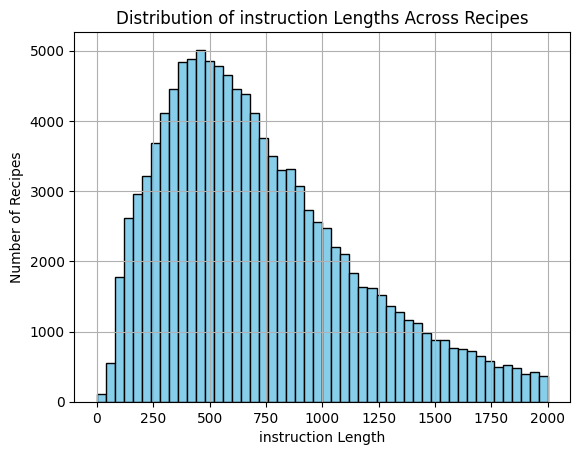

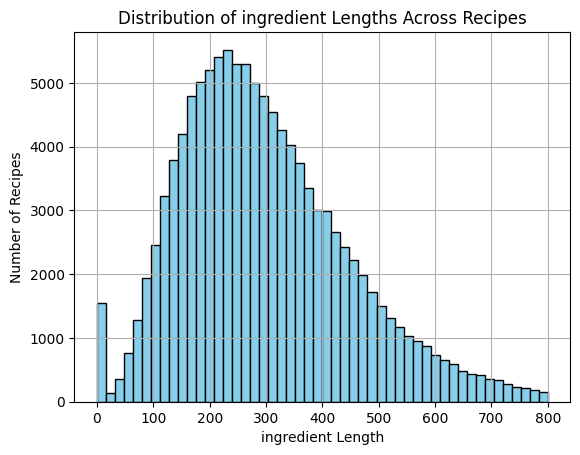

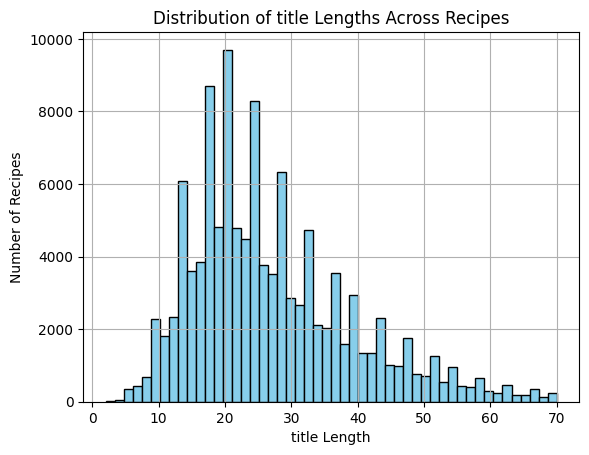

In [10]:

# Create a list to store keys of recipes with instructions longer than 3000 characters
keys_to_remove = []

# Iterate over each dictionary in combined_dict
for key, recipe_details in combined_dict.items():

    # Check if the length of instructions is greater than 2000 characters or ingredients greater than 800 characters
    if len(recipe_details['instructions']) > 2000 or len(recipe_details['ingredients']) > 800 or len(recipe_details['title']) > 70:
        # Add the key to the list of keys to remove
        keys_to_remove.append(key)

# Remove the recipes with instructions
for key in keys_to_remove:
    combined_dict.pop(key)

print("Recipes removed because ingredients or instructions too long:", len(keys_to_remove))

# Plot of recipe length

for var in ['instruction','ingredient','title']:
    # Extract the lengths for each recipe
    if var == 'title':
        var_plural = var
    else:
        var_plural = var + 's'
    lengths = [len(recipe_details[var_plural]) for recipe_details in combined_dict.values() if var_plural in recipe_details]

    plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel(f'{var} Length')
    plt.ylabel('Number of Recipes')
    plt.title(f'Distribution of {var} Lengths Across Recipes')
    plt.grid(True)
    plt.show()


#Step 5: Generating a dataframe for the clean data and saving

In [11]:

# Initialize lists to store values
key_id = []
title = []
ingredients = []
instructions = []

# Iterate through the dictionary
for key, value in combined_dict.items():
        key_id.append(key)
        title.append(value['title'])
        ingredients.append(value['ingredients'])
        instructions.append(value['instructions'])

# Create a DataFrame
recipe_df = pd.DataFrame({
    'key_id' : key_id,
    'title': title,
    'ingredients': ingredients,
    'instructions': instructions
})


In [12]:
recipe_df.head()

,key_id,title,ingredients,instructions
0,05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby,Christmas Eggnog,12 egg whites\n12 egg yolks\n1 1/2 cups sugar\...,"Beat the egg whites until stiff, gradually add..."
1,mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S,"Veal, Carrot and Chestnut Ragoût",18 fresh chestnuts\n2 1/2 pounds veal stew mea...,Preheat oven to 400 degrees F. Using small sha...
2,oQV5D7cVbCFwmrDs3pBUv2y.AG0WV26,Caramelized Bread Pudding with Chocolate and C...,"2 tablespoons unsalted butter, softened\n4 or ...",Preheat the oven to 350 degrees F. Spread the ...
3,Z9seBJWaB5NkSp4DQHDnCAUBTwov/1u,Sherried Stilton and Green Peppercorn Spread,"3/4 pound Stilton, crumbled (about 3 cups) and...","In a food processor blend the Stilton, the cre..."
4,bB3GxoAplVZeoX3fzWNWyeECtQFxw6G,Almond-Chocolate Macaroons,"2 cups (about 9 1/2 ounces) whole almonds, toa...",Position rack in center of oven and preheat to...


In [ ]:
recipe_df.to_pickle('recipe_df.pkl')